In [9]:
import pandas as pd
import xml.etree.ElementTree as ET

In [10]:
data = pd.read_csv('data/predictions_small.csv')
data = data.drop(data.columns[0], axis=1)
data['path'] = data['path'].apply(lambda x: str(x)[60:]) #Only keep the general folder structure

In [11]:
#This could probably be made a lot more efficiently
#Extract the PublicIdentifiers from the files that are in the prediction dataset
paths = data['path'].unique() #Extract all the unique paths
public_ids = {}
for path in paths:
    tree = ET.parse(f"data/{path}")
    f = tree.find('NewsItem') #Traverse down the xml file
    public_ids[path] = list(f.iter('PublicIdentifier'))[0].text

data['PublicID'] = data['path'].map(public_ids)
del public_ids
data.head()

,path,sentence,prediction,PublicID
0,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,India skipper Virat Kohli on Wednesday credite...,1,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
1,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""There is always too much noise and too much c...",1,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
2,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""The reason for our success has been that we h...",1,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
3,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,England captain Joe Root said Test players sho...,2,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...
4,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""I think that's part and parcel of Test cricke...",0,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...


In [12]:
#Add Asrael's URI's to the dataset. Note that some ID's can't be matched
URIs = pd.read_csv("Data/URI_ID.csv")
data = data.join(URIs.set_index('Identifier'), on='PublicID')
del URIs
data.head()

,path,sentence,prediction,PublicID,URI
0,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,India skipper Virat Kohli on Wednesday credite...,1,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
1,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""There is always too much noise and too much c...",1,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
2,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""The reason for our success has been that we h...",1,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
3,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,England captain Joe Root said Test players sho...,2,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
4,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""I think that's part and parcel of Test cricke...",0,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN


In [16]:
classes = {1: "cause", 2: "enable", 3: "intend", 4: "prevent"} #The classes to replace in the dataframe
data['prediction'] = data['prediction'].replace(classes)
del classes
data.head()

,path,sentence,prediction,PublicID,URI
0,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,India skipper Virat Kohli on Wednesday credite...,cause,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
1,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""There is always too much noise and too much c...",cause,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
2,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""The reason for our success has been that we h...",cause,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
3,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,England captain Joe Root said Test players sho...,enable,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN
4,afp_2021/2021/03/03/afp.com-20210303T141025Z-T...,"""I think that's part and parcel of Test cricke...",0,urn:newsml:afp.com:20210303T141025Z:TX-PAR-TVY...,NaN


In [24]:
data = data.dropna() #For now remove the rows which don't have an URI. Have to check if this is the right way

In [27]:
#Create a graph based on the created dataframe

#from owlready2 import *
from rdflib import Graph, Literal, RDF, URIRef, OWL, Namespace

rnews = Namespace("http://iptc.org/std/rNews/2011-10-07#")
prov = Namespace("http://www.w3.org/ns/prov#")
nif = Namespace("http://persistence.uni-leipzig.org/nlp2rdf/ontologies/nif-core#")
faro = Namespace("http://purl.org/faro/")

graph = Graph()

for index, row in data.iterrows():

    graph.add((Literal(row['URI'], datatype="http://www.w3.org/2001/XMLSchema#anyURI"), RDF.type, rnews.Article )) #Add the URI as article
    graph.add((Literal(row['URI'], datatype="http://www.w3.org/2001/XMLSchema#anyURI"), rnews.identifier, Literal(row['PublicID']))) #Link the PublicID to the article
    graph.add((Literal(row['sentence']), prov.wasDerivedFrom, Literal(row['URI'], datatype="http://www.w3.org/2001/XMLSchema#anyURI"))) #Add the sentence as part of the article
    graph.add((Literal(row['sentence']), RDF.type, nif.Sentence)) #Make the sentence of class 'Sentence'
    graph.add(((Literal(row['sentence']), nif.category, Literal(row['prediction'])))) #Add the class of the sentence

#0 property?
faro_classes = {'cause': faro.causes, 'enable': faro.enables, 'intend': faro.intends_to_cause, 'prevent': faro.prevents} #dict of faro definitions

for key, value in faro_classes.items():
    graph.add((Literal(key), RDF.type, value))

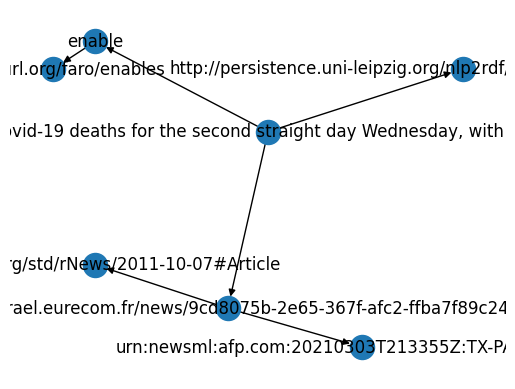

In [29]:
import networkx as nx
from rdflib.extras.external_graph_libs import rdflib_to_networkx_multidigraph
import matplotlib.pyplot as plt

nx_graph = rdflib_to_networkx_multidigraph(graph)
pos = nx.spring_layout(nx_graph, scale=2)

edge_labels = nx.get_edge_attributes(nx_graph, 'r')
nx.draw_networkx_edge_labels(nx_graph, pos, edge_labels=edge_labels)
nx.draw(nx_graph, with_labels=True)